In [127]:
!pip install datasets
!pip install transformers

import os
import zipfile
import logging
import json
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import hashlib

import transformers
from PIL import Image
from tqdm import tqdm

from google.colab import userdata

## Fetch Dataset

In [ ]:
if not os.path.exists("./data/"):
    os.makedirs("./data/")
os.environ['KAGGLE_USERNAME'] = userdata.get('kaggle_username')
os.environ['KAGGLE_KEY'] = userdata.get('kaggle_key')
!kaggle datasets download -d gsimonx37/letterboxd -p data/

with zipfile.ZipFile('./data/letterboxd.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/leterboxd')

os.remove('./data/letterboxd.zip')

## Datasampling

In [93]:
DATA_SIZE = 40000

In [94]:
def preprocess_image(image, target_shape=(345, 230)):
    """ Preprocess the image: resize, normalize, and apply augmentations.

    Args:
        image (Tensor): the image tensor
        target_shape (tuple): the desired shape of the image (height, width)

    Returns:
        Tensor: the preprocessed image
    """
    grey_to_rgb = transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
        
    preprocess = transforms.Compose([
        transforms.Resize(target_shape),
        transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
    ])
    return preprocess(grey_to_rgb(image))

In [95]:
def sample_data_balanced(genre_path: list, img_dir: str, test_split: float = 0.3, valid_split: float = 0.2, save_dataset: bool = False) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, list]:
    """ Reads the downloaded csv files, loads images from directory, one-hot-encodes the genres, 
        samples the train-data with respect to balanced classes.

    Args:
        paths (list): the csv-paths, [0] = genre-csv-file
        img_dir (str): directory containing the images
        test_split (float): proportion of the dataset to include in the test split
        valid_split (float): proportion of the training dataset to include in the validation split
        save_dataset (bool): if true the resulting dataset is saved

    Returns:
        pd.DataFrame: balanced train-data-set
        pd.DataFrame: real test-data-set
        pd.DataFrame: validation-data-set
        list: list of the unique-genres in the data
    """

    def one_hot_encode(genres_list, unique_genres):
        return [1 if genre in genres_list else 0 for genre in unique_genres]

    genres = pd.read_csv(genre_path, header=0)
    genres_gb = genres.groupby('id')['genre'].apply(list).reset_index()

    dataset = []
    images = os.listdir(img_dir)
    random.shuffle(images)
    images = images[:DATA_SIZE]
    for file_name in tqdm(images):
        if file_name.endswith(".jpg") or file_name.endswith(".png"):
            movie_id = int(os.path.splitext(file_name)[0]) 
            genre_row = genres_gb[genres_gb['id'] == movie_id]
            if not genre_row.empty:
                genres_list = genre_row['genre'].values[0]
                img_path = os.path.join(img_dir, file_name)
                try: 
                    img = preprocess_image(read_image(img_path).to(torch.float))
                except RuntimeError:
                    continue
                
                dataset.append({'id': movie_id, 'image': img, 'genre': genres_list})

    dataset = pd.DataFrame(dataset)

    dataset.dropna(subset=['genre', 'image'], inplace=True)

    unique_genres = sorted(set(genre for sublist in dataset['genre'] for genre in sublist))

    test_dataset_sampled = dataset.sample(frac=test_split)
    dataset = dataset.drop(test_dataset_sampled.index).reset_index(drop=True)
    test_dataset_sampled = test_dataset_sampled.reset_index(drop=True)
    one_hot_encoded = np.array(test_dataset_sampled['genre'].apply(lambda x: one_hot_encode(x, unique_genres)))
    test_dataset = test_dataset_sampled.assign(genre=one_hot_encoded.tolist())

    min_class_size = int(len(dataset) / len(unique_genres))

    train_dataset_sampled = pd.DataFrame()
    for genre in unique_genres:
        genre_subset = dataset[dataset['genre'].apply(lambda x: genre in x)]
        if not genre_subset.empty:
            if len(genre_subset) > min_class_size:
                genre_sampled = resample(genre_subset, replace=False, n_samples=min_class_size)
            else:
                genre_sampled = resample(genre_subset, replace=True, n_samples=min_class_size)
            train_dataset_sampled = pd.concat([train_dataset_sampled, genre_sampled])

    train_dataset_sampled = train_dataset_sampled.sample(frac=1).reset_index(drop=True)
    one_hot_encoded = np.array(train_dataset_sampled['genre'].apply(lambda x: one_hot_encode(x, unique_genres)))
    train_dataset = train_dataset_sampled.assign(genre=one_hot_encoded.tolist())

    train_dataset, valid_dataset = train_test_split(train_dataset, test_size=valid_split)

    train_dataset = train_dataset.reset_index(drop=True)
    valid_dataset = valid_dataset.reset_index(drop=True)

    if save_dataset:
        os.makedirs('./data', exist_ok=True)
        train_dataset.to_csv(f"./data/train_dataset.csv", index=False)
        test_dataset.to_csv(f"./data/test_dataset.csv", index=False)
        valid_dataset.to_csv(f"./data/valid_dataset.csv", index=False)

    return train_dataset, test_dataset, valid_dataset, unique_genres

In [96]:
train_dataset, test_dataset, valid_dataset, unique_genres = sample_data_balanced("../letterboxd/genres.csv", "../letterboxd/posters", 0.3, 0.2)
# for google colab
#train_dataset, test_dataset, valid_dataset, unique_genres = sample_data_balanced(['/content/data/leterboxd/genres.csv', '/content/data/leterboxd/movies.csv'], 0.3, 0.2)

100%|██████████| 40000/40000 [01:11<00:00, 555.59it/s]


In [97]:
def get_shape(tensor):
    return tensor.shape

print(f"Unique shapes of the train images:\t{train_dataset['image'].apply(get_shape).unique()}")
print(f"Unique shapes of the test images:\t{test_dataset['image'].apply(get_shape).unique()}")
print(f"Unique shapes of the valid images:\t{valid_dataset['image'].apply(get_shape).unique()}")


Unique shapes of the train images:	[torch.Size([3, 345, 230])]
Unique shapes of the test images:	[torch.Size([3, 345, 230])]
Unique shapes of the valid images:	[torch.Size([3, 345, 230])]


In [98]:
# test if the intersection between train and test data is empty
def tensor_to_hash(tensor):
    tensor_bytes = tensor.numpy().tobytes()
    return hashlib.md5(tensor_bytes).hexdigest()

train_dataset['image_hash'] = train_dataset['image'].apply(tensor_to_hash)
test_dataset['image_hash'] = test_dataset['image'].apply(tensor_to_hash)
merged = pd.merge(train_dataset, test_dataset, on=['image_hash'], how='inner')

if merged.empty:
    print("The intersection between train and test data is empty!")
else:
    print("The common data found: ", merged.shape)
    common_hashes = merged['image_hash'].unique()
    train_dataset = train_dataset[~train_dataset['image_hash'].isin(common_hashes)].reset_index(drop=True)
    test_dataset = test_dataset[~test_dataset['image_hash'].isin(common_hashes)].reset_index(drop=True)

# Hashwerte-Spalte entfernen, da sie nicht mehr benötigt wird
train_dataset.drop(columns=['image_hash'], inplace=True)
test_dataset.drop(columns=['image_hash'], inplace=True)

The common data found:  (14, 7)


## Analysis of the data

In [99]:
def show_samples(data: pd.DataFrame, unique_genres: list, num_samples: int = 5):
    """Displays a specified number of sample images with their corresponding labels.

    Args:
        data (pd.DataFrame): dataset with images 
        unique_genres (list): unique 
        num_samples (int): number of samples
    """
    sample_data = data.sample(num_samples).reset_index(drop=True)
    
    plt.figure(figsize=(15, num_samples * 3))
    
    for idx in range(num_samples):
        image_tensor = sample_data.iloc[idx]['image']
        image = to_pil_image(image_tensor)
        
        one_hot_label = sample_data.iloc[idx]['genre']
        genres = [unique_genres[i] for i in range(len(one_hot_label)) if one_hot_label[i] == 1]

        plt.subplot(num_samples, 1, idx + 1)
        plt.imshow(image)
        plt.title(f"Genres: {', '.join(genres)}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

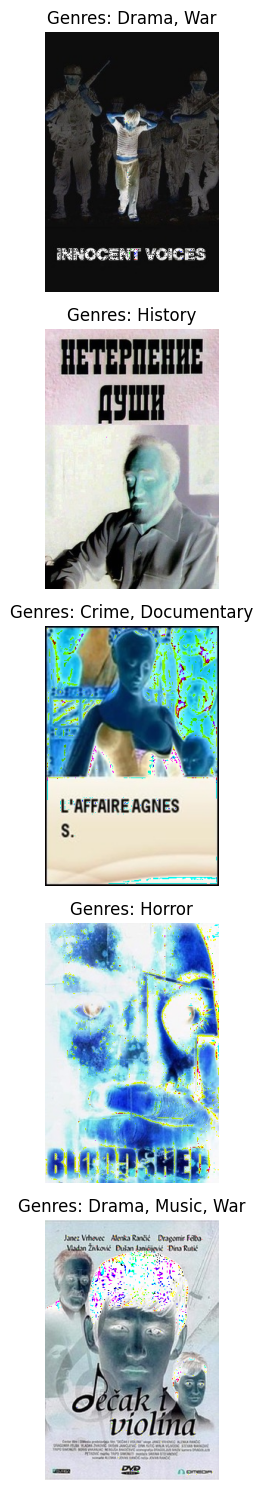

In [100]:
show_samples(train_dataset, unique_genres, num_samples=5)


In [101]:
def plot_genre_distribution(data: pd.DataFrame, unique_genres: list) -> None:
    genres = np.array(data['genre'].tolist())
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    axs[0].hist(genres.sum(axis=1), bins=range(1, genres.sum(axis=1).max()), color='skyblue', edgecolor='black')
    axs[0].set_title('Number of Genres per Movie', fontsize=16)
    axs[0].set_xlabel('Number of Genres', fontsize=14)
    axs[0].set_ylabel('Count', fontsize=14)
    axs[0].grid(True, linestyle='--', alpha=0.7)
    
    genre_counts = genres.sum(axis=0)
    genre_df = pd.DataFrame({'Genre': unique_genres, 'Count': genre_counts})
    sns.barplot(y='Genre', x='Count', data=genre_df, ax=axs[1], palette='viridis', hue='Genre', dodge=False)
    axs[1].set_title('Number of Occurrences per Genre', fontsize=16)
    axs[1].set_xlabel('Count', fontsize=14)
    axs[1].set_ylabel('Genre', fontsize=14)
    axs[1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

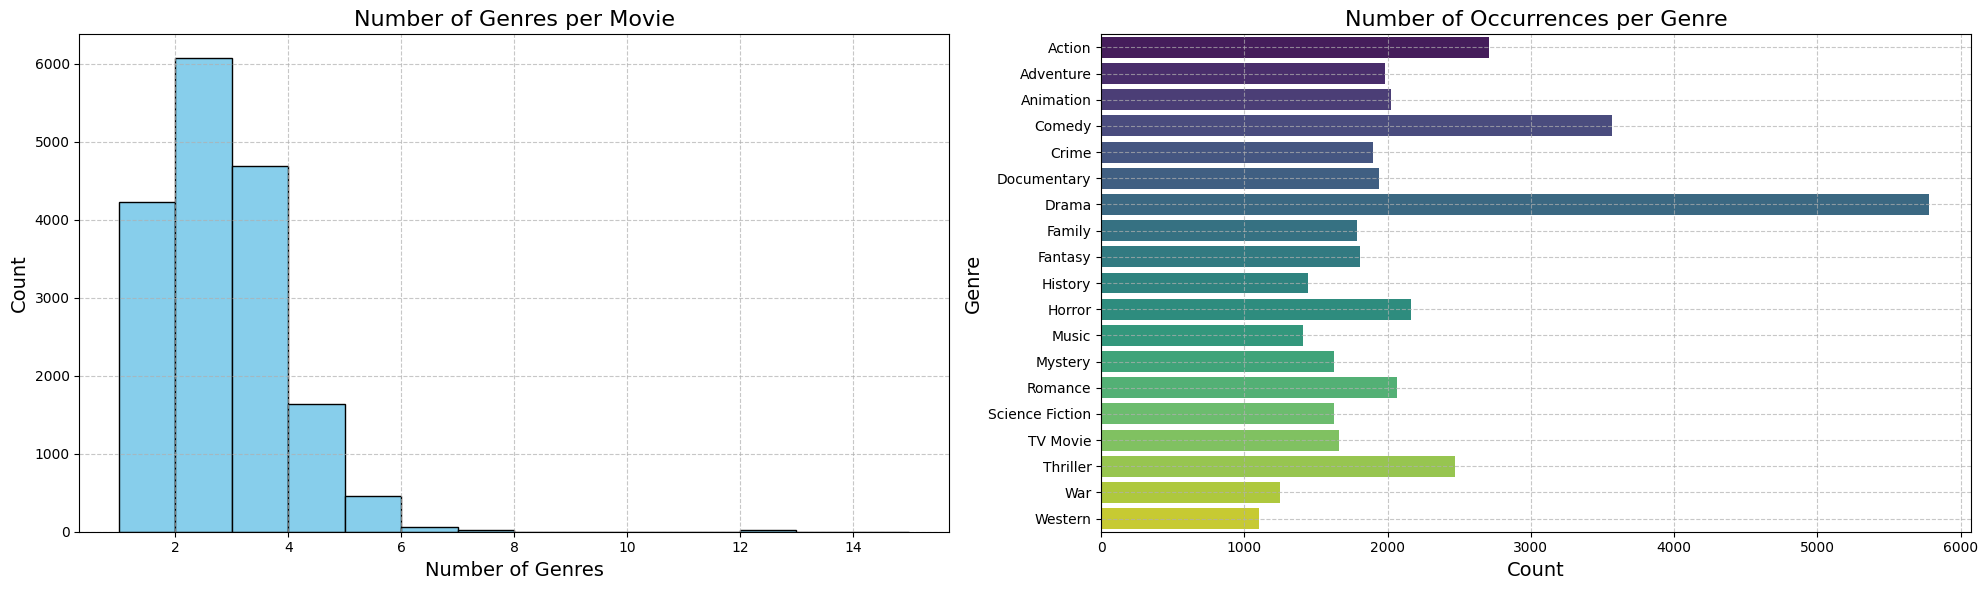

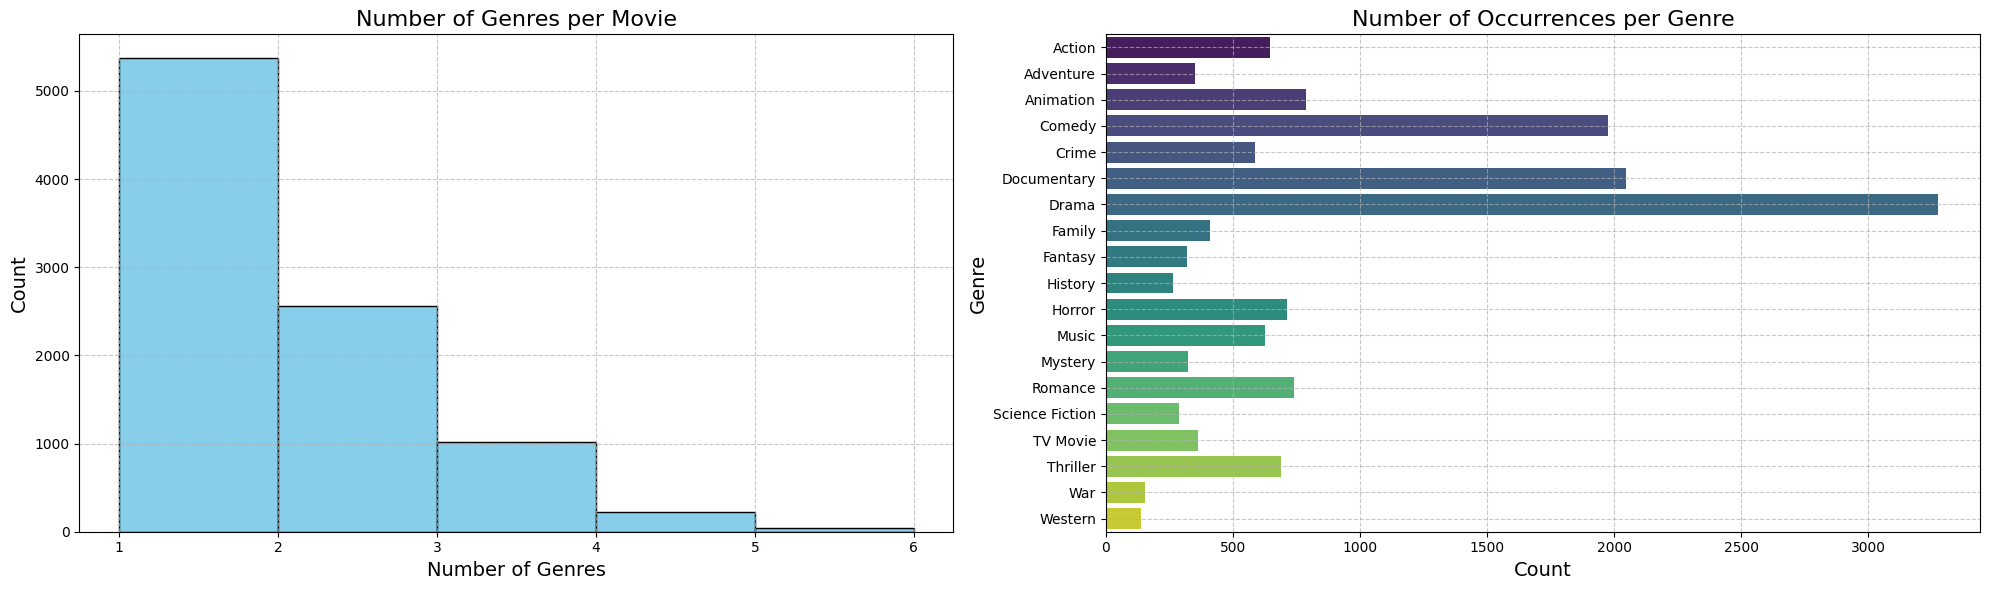

In [102]:
plot_genre_distribution(train_dataset, unique_genres)
plot_genre_distribution(test_dataset, unique_genres)

In [103]:
def plot_drama_distribution(data, unique_genres):
    drama_index = unique_genres.index('Drama')
    genres = np.array(data['genre'].tolist())
    is_drama = genres[:, drama_index] == 1
    is_not_drama = ~is_drama
    drama_genres = genres[is_drama]
    other_genres = genres[is_not_drama]

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    bins = range(1, max(drama_genres.sum(axis=1).max(), other_genres.sum(axis=1).max()))

    axs[0].hist(drama_genres.sum(axis=1), bins=bins, color='skyblue', edgecolor='black')
    axs[0].set_title('Number of Genres per Drama-Movie', fontsize=16)
    axs[0].set_xlabel('Number of Genres', fontsize=14)
    axs[0].set_ylabel('Count', fontsize=14)
    axs[0].grid(True, linestyle='--', alpha=0.7)

    axs[1].hist(other_genres.sum(axis=1), bins=bins, color='skyblue', edgecolor='black')
    axs[1].set_title('Number of Genres per Movie of the Rest', fontsize=16)
    axs[1].set_xlabel('Number of Genres', fontsize=14)
    axs[1].set_ylabel('Count', fontsize=14)
    axs[1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

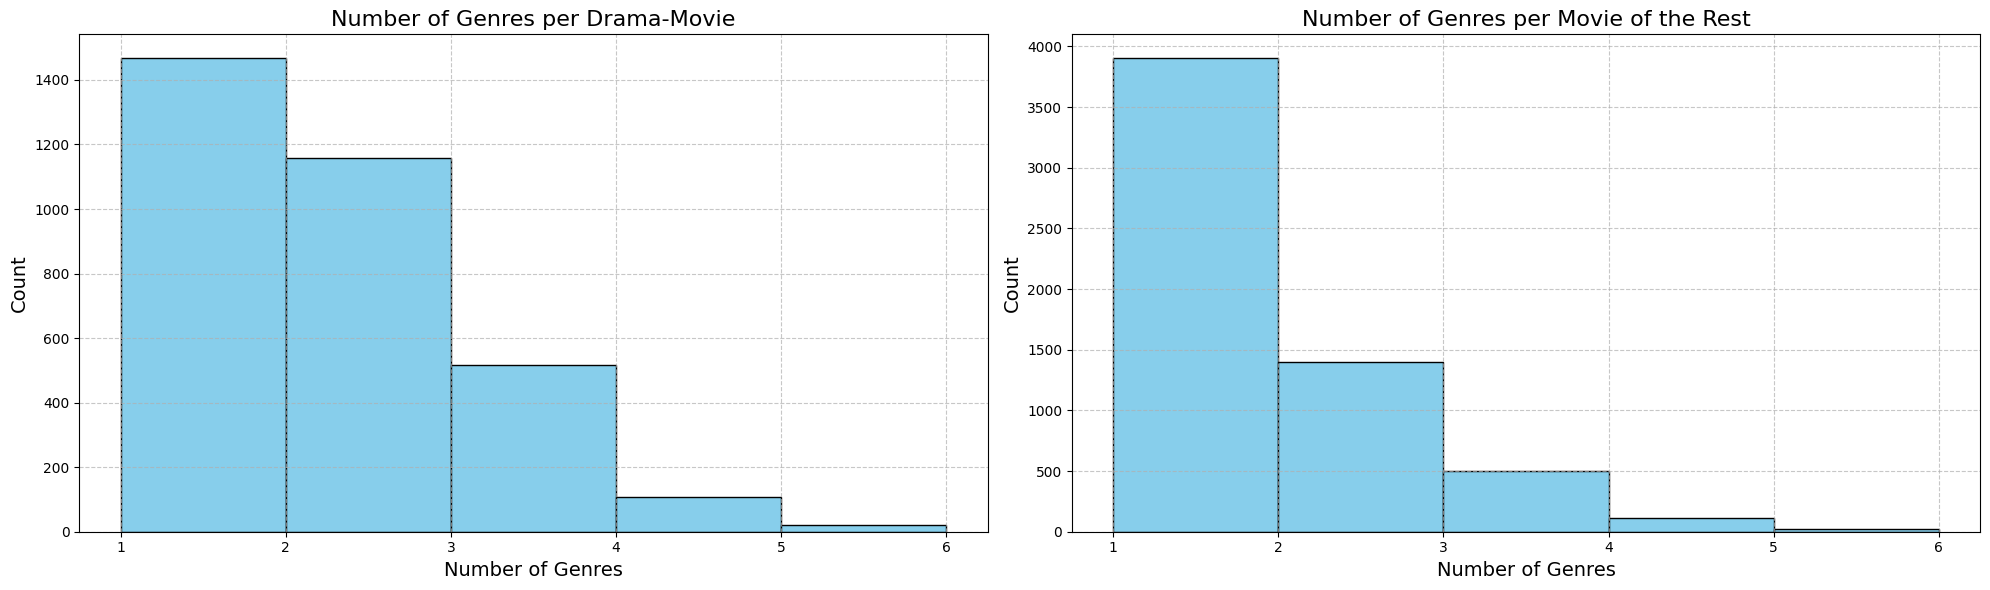

In [104]:
plot_drama_distribution(test_dataset, unique_genres)

## Create Torch-Dataset

In [111]:
class PosterDataset(Dataset):
    def __init__(self, images, genres_one_hot_encoded):
        self.images = images
        self.genres = genres_one_hot_encoded
        
    def batch_tokenizer(self, sentence):
        return self.tokenizer(sentence, truncation=True)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        X = torch.Tensor(self.images[idx]).to(torch.float32)
        y = torch.Tensor(self.genres[idx])
        return X, y

In [112]:
test_data = PosterDataset(test_dataset['image'], test_dataset['genre'])
train_data = PosterDataset(train_dataset['image'], train_dataset['genre'])
valid_data = PosterDataset(valid_dataset['image'], valid_dataset['genre'])

print(f"length of train dataset:\t{len(train_data)}")
print(f"length of test dataset:\t\t{len(test_data)}")
print(f"length of valid dataset:\t{len(valid_data)}")

length of train dataset:	17208
length of test dataset:		9220
length of valid dataset:	4306


In [113]:
def get_data_loader(dataset, batch_size, shuffle=False):
    """
    DataLoader for the given dataset with a specified batch size and shuffle option

    Args:
        dataset (torch.utils.data.Dataset): dataset to be loaded 
        batch_size (int): number of samples per batch
        shuffle (bool, optional): shuffle the data at every epoch

    Returns:
        torch.utils.data.DataLoader: DataLoader object 
    """
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return data_loader

In [114]:
batch_size = 32

train_data_loader = get_data_loader(train_data, batch_size, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size)
test_data_loader = get_data_loader(test_data, batch_size)

## Image Classification Model

In [85]:
class Metrics:
    '''
        metrics[0]  train loss
        metrics[1]  val loss
        metrics[2]  train error
        metrics[3]  val error
    '''
    def __init__(self):
        self.names = ['train loss', 'val loss', 'train error', 'val error']
        self.metrics = [[], [], [], []]
        self.epochs = 0
        self.is_numpy = False
        

    def add(self, train_loss=-1, test_loss=-1, train_acc=-1, test_acc=-1):
        values = [train_loss, test_loss, 100*(1.-train_acc), 100*(1.-test_acc)]
        for value, metric in zip(values, self.metrics):
            metric.append(value)
        self.epochs += 1

    def min(self, type=3):
        return np.min(self.metrics[type])

    def numpy(self):
        self.metrics = np.array(self.metrics)
        self.is_numpy = True
        return self

    def info(self):
        print(f'Epoch {self.epochs:>5}:    ', end='')
        for name, metric in zip(self.names, self.metrics):
            print(name, ':', f'{metric[-1]:7.3f} | ', end='')
        print()

    def plot_results(self, file=None):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        epochs = range(1, self.epochs + 1)
        
        axs[0].plot(epochs, self.metrics[0], label='Train Loss', color='blue', linestyle='-', marker='o')
        axs[0].plot(epochs, self.metrics[1], label='Validation Loss', color='orange', linestyle='-', marker='x')
        axs[0].set_title('Loss over Epochs', fontsize=14)
        axs[0].set_xlabel('Epochs', fontsize=12)
        axs[0].set_ylabel('Loss', fontsize=12)
        axs[0].legend()
        axs[0].grid(True)
        
        axs[1].plot(epochs, self.metrics[2], label='Train Error', color='green', linestyle='-', marker='o')
        axs[1].plot(epochs, self.metrics[3], label='Validation Error', color='red', linestyle='-', marker='x')
        axs[1].set_title('Error over Epochs', fontsize=14)
        axs[1].set_xlabel('Epochs', fontsize=12)
        axs[1].set_ylabel('Error (%)', fontsize=12)
        axs[1].legend()
        axs[1].grid(True)
        
        plt.tight_layout()
        if file:
            plt.savefig(file, bbox_inches='tight')
        plt.show()

In [160]:
class PosterClassifier(nn.Module):
    def __init__(self,  conv_params, fc_params, n_classes):
        super().__init__()

        self.n_output = n_classes
        conv_blocks = []
        for (n_convs, out_channels) in conv_params:
            conv_blocks.append(self._conv_block(n_convs, out_channels))

        self.net = nn.Sequential(
            *conv_blocks,
            nn.Flatten(),
            self._fc_block(fc_params, n_classes))

        self.loss_fn = self._get_loss_fn()
        self.device = self._get_device()
        self.to(self.device)
        print('=== model is on device', self.device, " ===", sep=' ')


    def forward(self, x):
        return self.net(x)

    def fit(self, train_loader, test_loader, optimizer, 
            patience=-1, epochs=10, log_freq=1):

        early_stop = EarlyStopping(patience) if patience > 0 else None
        best_model = None
        metrics = Metrics()

        # training
        for t in range(1, epochs+1):

            # train and test step
            tr_loss, tr_acc = self.train_step(train_loader, optimizer)
            te_loss, te_acc, _, _ = self.test_step(test_loader)

            # logging
            metrics.add(tr_loss, te_loss, tr_acc, te_acc)
            if t % log_freq == 0:
                metrics.info()
            
            # early stopping
            if early_stop:
                early_stop(te_loss)
                if early_stop.improved:
                    best_model = copy.deepcopy(self.state_dict())
                if early_stop.terminate:
                    print(f'Stopping early at epoch {t}')
                    break
            if np.isinf(tr_loss) or np.isnan(tr_loss):
                print(f'Loss is nan or inf at epoch {t}')
                break

        if best_model: 
            self.load_state_dict(best_model)

        return self, metrics   
    

    def train_step(self, dataloader, optimizer):
        self.train()
        size = len(dataloader.dataset)
        train_loss, train_acc = 0, 0
        for batch in dataloader:

            X = batch[0].to(self.device)
            y = batch[1].to(self.device)

            y_hat = self(X)
            loss = self.loss_fn(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(y)
            train_acc += self._score(y_hat, y)

        train_loss /= size
        train_acc /= size * self.n_output
        return train_loss, train_acc

    def test_step(self, dataloader):
        if not dataloader:
            return 0, 0
        
        self.eval()
        size = len(dataloader.dataset)
        test_loss, test_acc = 0, 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in dataloader:

                X = batch[0].to(self.device)
                y = batch[1].to(self.device)

                y_hat = self(X)
                loss = self.loss_fn(y_hat, y)
                
                test_loss += loss.item() * len(y)
                test_acc += self._score(y_hat, y)

                all_preds.append(y_hat.cpu())
                all_labels.append(y.cpu())
                

        test_loss /= size
        test_acc /= size * self.n_output
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        test_f1_micro, test_f1_marco = self._calculate_f1(all_preds, all_labels)
        return test_loss, test_acc, test_f1_micro, test_f1_marco
    
    def score(self, data):
        _, test_acc, f1_micro_score, f1_marco_score = self.test_step(data)
        return test_acc, f1_micro_score, f1_marco_score



    ### Auxiliary methods #####################################################
    def _get_device(self):
        return (
            "cuda" if torch.cuda.is_available()
            else 
            "mps" if torch.backends.mps.is_available()
            else 
            "cpu"
        )
    
    def _score(self, y_hat, y):
        y_hat = torch.sigmoid(y_hat)
        predictions = (y_hat >= 0.3).float()
        return (predictions == y).type(torch.float).sum().item() 
    
    def _calculate_f1(self, y_hat, y):
        y_hat = torch.sigmoid(y_hat)
        y_pred = (y_hat >= 0.3).float()
        return f1_score(y.numpy(), y_pred.numpy(), average='micro'), f1_score(y.numpy(), y_pred.numpy(), average='macro')
    
    def _get_loss_fn(self):
        return nn.BCEWithLogitsLoss()
    
    def _conv_block(self, n_convs, out_channels):
        layers = []
        for _, out_channels in zip(range(n_convs), out_channels):
            layers.append(nn.LazyConv2d(out_channels, kernel_size=5, padding=1, bias=False))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
        return nn.Sequential(*layers)
    
    def _fc_block(self, fc_params, n_classes):
        layers = []
        for units, dropout in fc_params:
            layers.append(nn.LazyLinear(units)), 
            layers.append(nn.ReLU()), 
            layers.append(nn.Dropout(dropout)),
        layers.append(nn.LazyLinear(n_classes))
        return nn.Sequential(*layers)
    
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.min_value = np.inf
        self.terminate = False
        self.improved = False
        
    def __call__(self, value):
        self.improved = False
        if value < self.min_value:
            self.min_value = value
            self.counter = 0
            self.improved = True
        elif value > self.min_value:
            self.counter += 1
        self.terminate = self.patience <= self.counter

## Training

In [161]:
def default_params(dropout: float = 0.5) -> tuple[dict, dict]:
    # parameters for Adam
    optim_params = dict(
        lr    = 0.001,           # learning rate
        betas = (0.9, 0.999),    # beta_1 and beta_2
        wd    = 0                # weight decay
    )

    # number of units
    params = dict(
        # parameters for adjusted lenet architecture
        conv_params =   ((2, [6, 16]), (2, [16, 16])),
        fc_params   =   ((240, dropout), (168, dropout)),
        patience    =   5,                # early stopping (patience <= 0: disabled)
        epochs      =   10,               # number of epochs
        log_freq    =   1,                # logging frequeny
        optim       =   optim_params      # parameters for optimizer
    )

    return params, optim_params

In [162]:
def run(train_data_loader, test_data_loader, params):
    p = copy.deepcopy(params)

    output_dim = len(unique_genres)

    model = PosterClassifier(p.pop("conv_params"), p.pop("fc_params"), output_dim)

    op = p.pop('optim')
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=op['lr'], 
        betas=op['betas'], 
        weight_decay=op['wd']
    )
    
    model, metrics = model.fit(train_data_loader, test_data_loader, optimizer, **p)

    return model, metrics

def eval(model, train_data, test_data):
    train_score, train_f1_micro, train_f1_macro = model.score(train_data)
    test_score, test_f1_micro, test_f1_macro = model.score(test_data)
    error_train = 1.0 - train_score
    error_test = 1.0 - test_score

    print(f'| train error : {100*error_train:.3f}% | train micro f1-score : {train_f1_micro:.3f} | train marcro f1-score : {train_f1_macro:.3f} |')
    print(f'| test error  : {100*error_test:.3f}% | test micro f1-score   : {test_f1_micro:.3f} | test macro f1-score : {test_f1_macro:.3f} |')

In [ ]:
params, optim_params = default_params(0.25)
optim_params['wd'] = 0
optim_params['lr'] = 0.002
optim_params['betas'] = (0.9, 0.999)
params['optim'] = optim_params
params['epochs'] = 10
params['log_freq'] = 1
model, metrics = run(train_data_loader, valid_data_loader, params)

In [ ]:
eval(model, train_data_loader, test_data_loader)

## Hyperparameter search

In [89]:
def check_and_create_runs_directory() -> None:
    runs_dir = "./runs"
    if not os.path.exists(runs_dir):
        os.makedirs(runs_dir)


def random_search(train_data, val_data, lr_interval: tuple, dropout_props: list, epochs: int = 20, trials: int = 10) -> tuple:
    best_run = np.inf

    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    def get_random_lr(lr_low=1e-5, lr_high=1e-1):
        return 10 ** np.random.uniform(np.log10(lr_low), np.log10(lr_high))

    for i in range(trials):
        learning_rate = get_random_lr(*lr_interval)
        dropout = random.choice(dropout_props)
        run_dir = f"./runs/run_{i}_lr_{learning_rate:.5f}"
        os.makedirs(run_dir, exist_ok=True)

        logging.info(f"=== RUN {i} | learning-rate: {learning_rate:.7f} | dropout: {dropout:.4f} ===")

        params, optim_params = default_params(dropout)
        params['epochs'] = epochs
        params['log_freq'] = 1
        params['optim'] = optim_params
        optim_params['lr'] = learning_rate
        optim_params['wd'] = 0
        model, metrics = run(train_data, val_data, params)

        plot_path = os.path.join(run_dir, f"results_lr_{learning_rate:.5f}.png")
        metrics.plot_results(plot_path)

        
        results = {
            'params': params,
            'optim_params': optim_params,
            'metrics': metrics.metrics
        }
        results_path = os.path.join(run_dir, 'results.json')
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=4)

        model_path = os.path.join(run_dir, 'model.pth')
        torch.save(model.state_dict(), model_path)

        if min(metrics.metrics[3]) < best_run:
            best_run = min(metrics.metrics[3])
            best_params = (params, optim_params)
            best_metrics = metrics
            best_model = model

    return best_params, best_metrics, best_model


In [ ]:
# search space 
lr_interval = (0.005, 0.0015)
dropout_props = np.arange(0.1, 0.5, 0.05)

check_and_create_runs_directory()
best_params, best_metrics, best_model = random_search(train_data_loader, valid_data_loader, lr_interval, dropout_props, epochs=10, trials=3)
eval(best_model, train_data_loader, test_data_loader)

## Visualize results

In [125]:
def show_predictions(model, data_loader, unique_genres: list, num_images: int = 5, threshold: float = 0.3, device: str = 'mps'):
    """
    Display a few images from the dataset along with their predicted and true labels.

    Args:
        model (torch.nn.Module): trained model
        data_loader (torch.utils.data.DataLoader): DataLoader for the dataset
        class_names (list): List of class names
        num_images (int): Number of images to display
        device (str): Device to run the model on
    """
    model.eval() 

    transform = transforms.Compose([
        transforms.ToPILImage(),
    ])

    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    
    with torch.no_grad():
        inputs, labels = next(iter(data_loader))
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = torch.sigmoid(model(inputs[:num_images]))
        preds = (outputs >= threshold).float()

        for i in range(num_images):
            output_pred = ''
            output_true = ''

            for prediction, true_labels, genre in zip(preds[i].tolist(), labels[i].tolist(), unique_genres):
                if prediction == 1:
                    output_pred += ' ' + genre
                if true_labels == 1:
                    output_true += ' ' + genre

            img = transform(inputs[i].cpu())

            axs[i].imshow(img)
            axs[i].set_title(f"True: {output_true}\nPred: {output_pred}")
            axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
show_predictions(model, test_data_loader, unique_genres)